### Feature Selection for Uplift Classification Problem
This notebook shows how to use CausalML data generation function to generate synthetic data and use feature selection functions to select important uplift features that affect the heterogeneous treatment effects.

### Setting up

In [35]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import itertools 
import time

In [7]:
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier

In [1]:
from causalml.dataset import make_uplift_classification_logistic
from causalml.feature_selection import FilterSelect

myUpSelect = FilterSelect()

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


### Define Functions

In [41]:
# Randomly split datasets into training and testing parts.
def split_data(n_total, train_proportion=0.5, random_seed=None):
        """
        Randomly split datasets into training and testing parts.
        """
        if random_seed is not None:
            np.random.seed(random_seed)
        train_size = int(np.floor(n_total * train_proportion))
        train_index = np.random.choice(n_total, size=train_size, replace=False)
        return(train_index)

In [2]:
# Uplift model evaluation function for synthetic data, output stats such as RMSE, AUUC
def uplift_evaluate(uplift_model, y_pred_full, y_test, df_test, treatment_group_keys, treatment_groups):
    df_user_res = pd.DataFrame()
    if my_uplift_model.evaluationFunction in ['RLearner', 'XLearner']:
        for treatment_group_key in treatment_groups:
            df_user_res[treatment_group_key] = y_pred_full[treatment_group_key]
            df_user_res['%s_effect_err'%(treatment_group_key)] = df_user_res[treatment_group_key].values - df_test['%s_true_effect'%(treatment_group_key)].values
        df_user_res['model'] = my_uplift_model.evaluationFunction
        df_user_res['treatment'] = df_user_res[treatment_groups].max(axis=1)
        df_user_res['delta'] = ( #[N] best treatment effect
            df_user_res['treatment'] 
            + np.random.uniform(0, 0.1**8, df_user_res.shape[0])
        )
    else:
        for treatment_group_key in treatment_group_keys:
            df_user_res[treatment_group_key] = y_pred_full[treatment_group_key]
            df_user_res['%s_effect_err'%(treatment_group_key)] = df_user_res[treatment_group_key].values - df_user_res['control'].values - df_test['%s_true_effect'%(treatment_group_key)].values
        df_user_res['model'] = method_criterion
        df_user_res['treatment'] = df_user_res[treatment_groups].max(axis=1)
        df_user_res['delta'] = ( #[N] best treatment effect
            df_user_res['treatment'] 
            - df_user_res['control'] 
            + np.random.uniform(0,0.1**8,df_user_res.shape[0])
        )
    df_user_res[y_name] = y_test
    
    conv_prob_names = ['control_conversion_prob']
    df_user_res['control_conversion_prob'] = df_test['control_conversion_prob'].values
    for treatment_group_key in treatment_groups:
        conv_prob_names.append('%s_conversion_prob'%(treatment_group_key))
        df_user_res['%s_conversion_prob'%(treatment_group_key)] = df_test['%s_conversion_prob'%(treatment_group_key)].values
        
    #for validation, create synthetic treatment group #[N][Q] meaning?
    df_user_res['best_treatment'] = df_user_res[treatment_groups].idxmax(axis=1)

    uplift = df_user_res

    # Cut predicted proba diff into deciles 
    quantiles = 100
    uplift['quantile'] = pd.qcut(uplift['delta'], quantiles, labels=range(1, 101))
    # Actual (T-C) by predicted proba diff deciles 
    deciles = uplift.groupby(['quantile'])[conv_prob_names].mean().reset_index()
    # Actual abs diff normalized by total sample size
    deciles['actual_diff'] = (deciles['%s_conversion_prob'%(treatment_group_key)] - deciles['control_conversion_prob']) / quantiles # there are 10 deciles #[N][Q] meaning of the comment?
    deciles = deciles.sort_index(ascending=False)
    # Cumulative actual diff
    deciles['cum_diff'] = deciles['actual_diff'].cumsum()
    # Cumulative actual diff percent of total actual diff #[N][Q] meaning?
    deciles['cum_pct'] = 100 * deciles['cum_diff'] / sum(deciles['actual_diff'])

    # Final summary results
    result_uplift_i = deciles.reset_index()
    result_uplift_i['sample_size'] = n
    result_uplift_i['model'] = method_criterion
    result_uplift_i['n_estimator'] = n_estimator
    result_uplift_i['max_feature'] = max_feature
    result_uplift_i['max_depth'] = max_depth
    result_uplift_i['min_samples_leaf'] = min_samples_leaf
    result_uplift_i['min_samples_treatment'] = min_samples_treatment
    result_uplift_i['n_reg'] = n_reg

    result_uplift_i['ID_setting_simu'] = ID_setting_simu
    result_uplift_i['ID_replicate'] = i_replicate
    result_uplift_i['top_n_features'] = top_n_features
    result_uplift_i['ID_setting_model'] = ID_setting_model
    result_uplift_i['AUUC_diff'] = result_uplift_i['cum_diff'].sum()*0.01
    result_uplift_i['AUUC_pct'] = result_uplift_i['cum_pct'].sum()*0.01
    
    result_uplift_i['effect_rmse'] = np.sqrt(np.mean(df_user_res['%s_effect_err'%(treatment_group_key)]**2))

    return result_uplift_i


In [3]:
# General parameters --------------------------------------------------------#
# These parameters will be used in simulation and analysis.
y_name = 'conversion'
experiment_group_key = 'treatment_group_key' # column name of treatment labels
treatment_group_keys = ['control', 'treatment1'] 
treatment_groups_ll = [['treatment1']] 
treatment_groups = treatment_groups_ll[0]
control_group = 'control'

In [27]:
# User-specified parameters: misc -------------------------------------------#
setting_simu_n_sample = [10**3] # sample size per treatment group
setting_n_replicate = 2 # number of replicate datasets

In [28]:
# Parameters for simulation -------------------------------------------------#

# user-spefied
setting_simu_n_classification_features = [30] # , 100, 200]
setting_simu_n_classification_informative = [10]
setting_simu_n_uplift_dict = [
    {'treatment1': 6}, # {'treatment1': 5}
]
setting_simu_n_mix_informative_uplift_dict = [
    {'treatment1': 0}, # {'treatment1': 5}
]
setting_simu_delta_uplift_dict = [
    {'treatment1': 0.1} # , {'treatment1': 0.3} 
]

# static - can be added when necessary
setting_simu_n_classification_redundant = [0]
setting_simu_n_classification_repeated = [0]

# static - usually no need to change
setting_simu_spl_s = [0.05]
setting_simu_spl_n_functions = [10]
setting_simu_spl_n_initial_points = [10]
setting_simu_noise_positive_class_proportion = [0.5]
setting_simu_noise_proportion = [0.01]

setting_control_positive_class_proportion = [0.2]

#setting_random_seed = 20191115

In [30]:
# Parameters for methods ----------------------------------------------------#
# Both the filter method and the uplift modeling parameters are specified here.

# user-specified
# Filter Method
#setting_filter_method = ['KL','ED', 'Chi','F','LR'] 
setting_filter_method = ['KL','ED'] 

# Top features 
setting_top_n_features = [5] 

# Uplift Models
xlearner = BaseXClassifier(control_outcome_learner=RandomForestClassifier(),
                           treatment_outcome_learner=RandomForestClassifier(),
                           control_effect_learner=RandomForestRegressor(),
                           treatment_effect_learner=RandomForestRegressor(),
                           control_name='control')

setting_model_methods = [
   xlearner
]

In [37]:
# Make parameter DataFrames -------------------------------------------------#

# DataFrame of simulation settings
setting_simu_list = [
    setting_simu_n_sample,
    setting_simu_n_classification_features,
    setting_simu_n_classification_informative,
    setting_simu_n_uplift_dict,
    setting_simu_n_mix_informative_uplift_dict,
    setting_simu_delta_uplift_dict,
    # static: skipped in the first attempt
    setting_simu_n_classification_redundant,
    setting_simu_n_classification_repeated,
    # static
    setting_simu_spl_s,
    setting_simu_spl_n_functions,
    setting_simu_spl_n_initial_points,
    setting_simu_noise_positive_class_proportion,
    setting_simu_noise_proportion,
    setting_control_positive_class_proportion,
]

setting_simu_dict = dict()
ID_setting_simu = 0

for one_setting_simu in itertools.product(*setting_simu_list):
    one_setting_simu_dict = {ID_setting_simu: list(one_setting_simu)}
    setting_simu_dict.update(one_setting_simu_dict)
    ID_setting_simu += 1

setting_simu_df = pd.DataFrame.from_dict(setting_simu_dict, orient='index',
    columns=['n',
             'n_classification_features',
             'n_classification_informative',
             'n_uplift_dict',
             'n_mix_informative_uplift_dict',
             'delta_uplift_dict',
             'n_classification_redundant',
             'n_classification_repeated',
             'spl_s', 
             'spl_n_functions',
             'spl_n_initial_points',
             'noise_positive_class_proportion',
             'noise_proportion',
             'control_positive_class_proportion']
)

# DataFrame of uplift model settings
setting_model_list = [
    setting_model_methods
]

setting_model_dict = dict()
ID_setting_model = 0

for one_setting_model in itertools.product(*setting_model_list):
    one_setting_model_dict = {ID_setting_model: list(one_setting_model)}
    setting_model_dict.update(one_setting_model_dict)
    ID_setting_model += 1

setting_model_df = pd.DataFrame.from_dict(setting_model_dict, orient='index',
    columns=['uplift_model']
)

In [38]:
# Setting up before getting started -----------------------------------------#
# This section sets up the objects to save the simulation results.

# Storage of the results
df1_summary = pd.DataFrame()
result_computing_time = pd.DataFrame()
result_filter = pd.DataFrame()
result_uplift = pd.DataFrame()

# Progress records
counter = 0

total_runs = (
    len(setting_simu_df.index) * setting_n_replicate 
    * len(setting_filter_method)
    * (len(setting_top_n_features)) 
    * len(setting_model_df.index)
) 

In [39]:
total_runs # to check progress

4

### Simulation

The following steps are taken in this main body of the code:

1. The data are simulated under each simulation setting.  The total number of datasets depends on the user-specified replicate number.
2. For each replicate dataset, the feature selection method is applied.
3. For each replicate dataset, the uplift modeling is done.
4. Save the results.

In [42]:
#----------------------------------------------------------------------------#
# Simulation: main body -----------------------------------------------------#
#----------------------------------------------------------------------------#

time_start = time.time()
print('Start time: {}'.format(time_start))

#np.random.seed(round(time_start))
np.random.seed(20191119)
seeds_for_setting_simu = np.random.choice(
    999999, size=len(setting_simu_df.index), replace=False
)

counter = 0 
# loop through simulation setting
for ID_setting_simu in range(len(setting_simu_df.index)):
    
    n = setting_simu_df.loc[ID_setting_simu, 'n']
    n_classification_features = setting_simu_df.loc[ID_setting_simu, 'n_classification_features']
    n_classification_informative = setting_simu_df.loc[ID_setting_simu, 'n_classification_informative']
    n_mix_informative_uplift_dict = setting_simu_df.loc[ID_setting_simu, 'n_mix_informative_uplift_dict']
    n_uplift_dict = setting_simu_df.loc[ID_setting_simu, 'n_uplift_dict']
    delta_uplift_dict = setting_simu_df.loc[ID_setting_simu, 'delta_uplift_dict']
    n_classification_redundant = setting_simu_df.loc[ID_setting_simu, 'n_classification_redundant']
    n_classification_repeated = setting_simu_df.loc[ID_setting_simu, 'n_classification_repeated']
    control_positive_class_proportion = setting_simu_df.loc[ID_setting_simu, 'control_positive_class_proportion']

    np.random.seed(seeds_for_setting_simu[ID_setting_simu])
    seeds_for_replicate = np.random.choice(
        999999, size=setting_n_replicate, replace=False
    )
    
    # loop through replicates
    for i_replicate in range(setting_n_replicate):
        df1, x_name_all = make_uplift_classification_logistic(
                            n_samples=n,
                            treatment_name=treatment_group_keys,
                            y_name=y_name,
                            n_classification_features=n_classification_features,
                            n_classification_informative=n_classification_informative,
                            n_classification_redundant=n_classification_redundant,
                            n_classification_repeated=0,
                            n_uplift_dict=n_uplift_dict,
                            n_mix_informative_uplift_dict=n_mix_informative_uplift_dict,
                            delta_uplift_dict=delta_uplift_dict,
                            positive_class_proportion = 0.1,
                            random_seed=20200101,
                            feature_association_list = ['linear','quadratic','cubic','relu','sin','cos'],
                            random_select_association = False
                            )

        # Make separate list of features
        x_name_classification_informative = [x_i for x_i in x_name_all 
                                             if x_i.split('_')[1] == 'informative']
        x_name_uplift = [x_i for x_i in x_name_all if x_i.split('_')[1] == 'uplift']
        x_name_redundant = [x_i for x_i in x_name_all if x_i.split('_')[1] == 'redundant']
        x_name_repeated = [x_i for x_i in x_name_all if x_i.split('_')[1] == 'repeated']
        x_name_irrelevant = [x_i for x_i in x_name_all if x_i.split('_')[1] == 'irrelevant']

        n_uplift = sum([n_i for n_i in n_uplift_dict.values()])
        n_relevant = n_classification_informative + n_uplift

        # Training-testing split
        train_index = split_data(n_total=len(df1.index)) # half by default

        df1['is_train'] = 0
        df1.loc[train_index, 'is_train'] = 1

        df1_train = df1.loc[df1['is_train'] == 1]
        df1_test = df1.loc[df1['is_train'] == 0]

        y_train= df1_train[y_name].values
        experiment_groups_train = df1_train[experiment_group_key].values

        y_test = df1_test[y_name].values
        experiment_groups_test = df1_test[experiment_group_key].values

        # Dataset summary
        df1_train_summary_i = df1_train.groupby(['treatment_group_key'])[y_name].mean()
        df1_test_summary_i = df1_test.groupby(['treatment_group_key'])[y_name].mean()
        df1_summary_i = pd.DataFrame([
            [ID_setting_simu, i_replicate]
            + df1_train_summary_i.tolist() 
            + df1_test_summary_i.tolist()],
            columns=(['ID_setting_simu', 'ID_replicate']
                     + ['{}_train'.format(x) for x in df1_train_summary_i.index.tolist()] 
                     + ['{}_test'.format(x) for x in df1_test_summary_i.index.tolist()]), 
        )
        df1_summary = pd.concat([df1_summary, df1_summary_i])
        


Start time: 1587102377.8208058


In [45]:
fs_method = FilterSelect()
# Apply filter methods
df_fs_result = pd.DataFrame()
for filter_method in setting_filter_method:
    # Get the filter-selection result, all features
    filter_result = fs_method.get_importance(data=df1_train, features=x_name_all, y_name=y_name, method=filter_method, 
              experiment_group_column='treatment_group_key',
              control_group = 'control', 
              treatment_group = 'treatment1',
              n_bins=5, 
              )
    if df_fs_result.shape[0]==0:
        df_fs_result = filter_result 
    else:
        df_fs_result = pd.concat([df_fs_result,filter_result],axis=0)

In [47]:
[0.5]*len(y_train)

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [49]:
x_name = x_name_all
x_train = df1_train[x_name].values
x_test = df1_test[x_name].values
top_n_features = len(x_name)
y_train= df1_train[y_name].values
experiment_groups_train = df1_train[experiment_group_key].values

xlearner.fit(X=x_train, treatment=experiment_groups_train, y=y_train, p=np.array([0.5]*len(y_train)))

In [52]:
y_pred_full = xlearner.predict(X=x_test, p=np.array([0.5]*len(x_test)), return_components=False,verbose=True)

y_pred_full

array([[ 0.04575],
       [ 0.16415],
       [ 0.25235],
       [ 0.1571 ],
       [ 0.0605 ],
       [ 0.01395],
       [ 0.03595],
       [ 0.13735],
       [ 0.03785],
       [ 0.1765 ],
       [ 0.08285],
       [ 0.1814 ],
       [ 0.138  ],
       [-0.0272 ],
       [ 0.1189 ],
       [ 0.10305],
       [ 0.11795],
       [ 0.0913 ],
       [ 0.0271 ],
       [ 0.01235],
       [ 0.2063 ],
       [ 0.05165],
       [ 0.10585],
       [ 0.08675],
       [ 0.043  ],
       [ 0.1651 ],
       [-0.01695],
       [ 0.08025],
       [ 0.03635],
       [ 0.2082 ],
       [-0.02375],
       [ 0.1581 ],
       [ 0.15215],
       [-0.06845],
       [ 0.12545],
       [ 0.0685 ],
       [ 0.1153 ],
       [ 0.0919 ],
       [-0.0314 ],
       [ 0.0768 ],
       [ 0.08445],
       [ 0.16675],
       [ 0.0531 ],
       [ 0.1327 ],
       [ 0.07325],
       [ 0.22285],
       [ 0.12065],
       [ 0.07765],
       [ 0.09205],
       [ 0.09565],
       [ 0.26675],
       [ 0.18255],
       [ 0.0

In [ ]:
        # Apply filter methods
        df_fs_result = pd.DataFrame()
        for filter_method in setting_filter_method:
            # Get the filter-selection result, all features
            filter_result = fs_method.get_importance(data=df_train, features=x_name_all, y_name, method=filter_method, 
                      experiment_group_column='treatment_group_key',
                      control_group = 'control', 
                      treatment_group = 'treatment1',
                      n_bins=5, 
                      )
            if df_fs_result.shape[0]==0:
                df_fs_result = filter_result 
            else:
                df_fs_result = pd.concat([df_fs_result,filter_result],axis=0)
        
        # Apply embedded methods  
        # learner dictionary
        learner_dict ={'Outcome': RandomForestClassifier(n_estimators = setting_model_n_estimator[0],
                                                          max_features = setting_model_max_feature[0],
                                                          min_samples_leaf = setting_model_min_samples_leaf[0],
                                                          random_state=0),
                      'TwoModel': UpliftRandomForestClassifier(evaluationFunction='TwoModel',
                                                               control_group=control_group,
                                                               n_estimators = setting_model_n_estimator[0],
                                                               max_features = setting_model_max_feature[0],
                                                               min_samples_leaf = setting_model_min_samples_leaf[0],
                                                               min_samples_treatment=setting_model_min_samples_treatment[0],
                                                               n_reg=setting_model_n_reg[0],
                                                               y_calibration_method=setting_model_y_calibration_method[0],
                                                               w_calibration_method=setting_model_w_calibration_method[0]),
                       'KL': UpliftRandomForestClassifier(evaluationFunction='KL',
                                                               control_group=control_group,
                                                               n_estimators = setting_model_n_estimator[0],
                                                               max_features = setting_model_max_feature[0],
                                                               min_samples_leaf = setting_model_min_samples_leaf[0],
                                                               min_samples_treatment=setting_model_min_samples_treatment[0],
                                                               n_reg=setting_model_n_reg[0],
                                                               y_calibration_method=setting_model_y_calibration_method[0],
                                                               w_calibration_method=setting_model_w_calibration_method[0]),
                      }
        for embedded_method in setting_embedded_method:
            # Get the embedded-selection result, all features
            embedded_result = myUpSelect.embedded_result(
                data=df1_train, 
                X_name_list=x_name_all, 
                y_name=y_name, 
                method=embedded_method,
                learner=learner_dict[embedded_method],
                experiment_group_column=experiment_group_key
            )
            if df_fs_result.shape[0]==0:
                df_fs_result = embedded_result
            else:
                df_fs_result = pd.concat([df_fs_result,embedded_result],axis=0)
        
        
        result_feature_recall = pd.DataFrame()
        
        # Feature selection Evaluation (Recall and Model accuracy)
        for ID_setting_model in range(len(setting_model_df.index)):
            # Load Model Setting
            method_criterion = setting_model_df.loc[ID_setting_model, 'method_criterion']
            max_feature = setting_model_df.loc[ID_setting_model, 'max_feature']
            n_estimator = setting_model_df.loc[ID_setting_model, 'n_estimator']
            max_depth = setting_model_df.loc[ID_setting_model, 'max_depth']
            min_samples_leaf = setting_model_df.loc[ID_setting_model, 'min_samples_leaf']
            min_samples_treatment = setting_model_df.loc[ID_setting_model, 'min_samples_treatment']
            n_reg = setting_model_df.loc[ID_setting_model, 'n_reg']
            y_calibration_method = setting_model_df.loc[ID_setting_model, 'y_calibration_method']
            w_calibration_method = setting_model_df.loc[ID_setting_model, 'w_calibration_method']
            #max_feature = min(max_feature, len(x_name)) # in case len(x_name) small

            # algorithm starts
            time_point1 = time.time()

            # Model with All Features
            x_name = x_name_all
            x_train = df1_train[x_name].values
            x_test = df1_test[x_name].values
            top_n_features = len(x_name)

            my_uplift_model = UpliftRandomForestClassifier(
                control_group=control_group,
                evaluationFunction=method_criterion,
                max_features=max_feature,
                # from previously
                n_estimators=n_estimator,
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                min_samples_treatment=min_samples_treatment,
                n_reg=n_reg,
                y_calibration_method=y_calibration_method,
                w_calibration_method=w_calibration_method
            )

            # Model with All Features
            my_uplift_model.fit(
                X=x_train, 
                experiment_groups=experiment_groups_train, 
                y=y_train
            )

            y_pred_full = my_uplift_model.predict(
                X=x_test, full_output=True
            )

            # Summarize Results into a DF
            result_uplift_i = uplift_evaluate(my_uplift_model, y_pred_full, y_test, df1_test, treatment_group_keys, treatment_groups)
            result_uplift_i['prop_classification_informative'] = 1.
            result_uplift_i['prop_uplift'] = 1.
            result_uplift_i['prop_relevant'] = 1.
            result_uplift_i['feature_selection_method'] = 'All'
            result_uplift = pd.concat(
                [result_uplift, result_uplift_i]
            ).reset_index(drop=True)

            time_point2 = time.time()
            time_diff = time_point2 - time_point1
            # print('Simulation Setting {}completed, time spent: %s'%(method_criterion, time_point2 - time_point1))
            result_computing_time_i = pd.DataFrame({
                'ID_setting_simu': ID_setting_simu,
                'sample_size': n,
                'ID_replicate': i_replicate,
                'top_n_features': top_n_features,
                'ID_setting_model': ID_setting_model,
                'model': method_criterion,
                'time': time_diff,
            }, index=[0])
            result_computing_time = pd.concat(
                [result_computing_time, result_computing_time_i]
            ).reset_index(drop=True)


            # Model with Top Features
            for top_n_features in setting_top_n_features:
                # Loop through FS method
                fs_methods = df_fs_result.method.unique()
                for fs_method in fs_methods:

                    x_name = df_fs_result[df_fs_result['method']==fs_method]['feature'].head(top_n_features).tolist()

                    # Evaluate Feature Recall: % of relevant features selected
                    # [result] Relevant features selected
                    x_selected_classification_informative = [
                        x_i for x_i in x_name 
                        if x_i in x_name_classification_informative
                    ]
                    x_selected_uplift = [x_i for x_i in x_name if x_i in x_name_uplift]

                    select_proportion_classification_informative = (
                        len(x_selected_classification_informative) 
                        / n_classification_informative
                    )
                    if n_uplift != 0:
                        select_proportion_uplift = len(x_selected_uplift) / n_uplift
                    else: 
                        select_proportion_uplift = 0.
                    select_proportion_relevant = (
                        (len(x_selected_classification_informative) + len(x_selected_uplift)) 
                        / n_relevant
                    )
                    # Uplift feature selected by linear / nonlinear pattern type
                    ## f_list = [self.f_linear,self.f_quadratic,self.f_cubic,self.f_relu, self.f_sin, self.f_cos]
                    uplift_feature_map = {x_name_uplift[0]: 'Linear',
                                         x_name_uplift[1]: 'Quadratic',
                                         x_name_uplift[2]: 'Cubic',
                                         x_name_uplift[3]: 'Relu',
                                         x_name_uplift[4]: 'Sin',
                                         x_name_uplift[5]: 'Cos',}
                    select_proportion_uplift_type ={}
                    for key, value in uplift_feature_map.items():
                        select_proportion_uplift_type[value] = 0.
                    for xi, x_name_i in enumerate(x_selected_uplift):
                        select_proportion_uplift_type[uplift_feature_map[x_name_i]] = 1.

                    result_feature_recall_i = pd.DataFrame({
                        'ID_setting_simu': ID_setting_simu,
                        'sample_size': n,
                        'ID_replicate': i_replicate,
                        'method': fs_method,
                        'top_n_features': top_n_features,
                        'prop_classification_informative': select_proportion_classification_informative,
                        'prop_uplift': select_proportion_uplift,
                        'prop_uplift_linear': select_proportion_uplift_type['Linear'],
                        'prop_uplift_quadratic': select_proportion_uplift_type['Quadratic'],
                        'prop_uplift_cubic': select_proportion_uplift_type['Cubic'],
                        'prop_uplift_relu': select_proportion_uplift_type['Relu'],
                        'prop_uplift_sin': select_proportion_uplift_type['Sin'],
                        'prop_uplift_cos': select_proportion_uplift_type['Cos'],
                        'prop_relevant': select_proportion_relevant,
                    }, index=[0])

                    result_feature_recall = pd.concat([result_feature_recall, result_feature_recall_i],axis=0)

                    # Model with top features
                    x_train = df1_train[x_name].values
                    x_test = df1_test[x_name].values

                    # Model with Top Features
                    max_feature_local = np.min([len(x_name),max_feature])
                    my_uplift_model = UpliftRandomForestClassifier(
                                    control_group=control_group,
                                    evaluationFunction=method_criterion,
                                    max_features=max_feature_local,
                                    # from previously
                                    n_estimators=n_estimator,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    min_samples_treatment=min_samples_treatment,
                                    n_reg=n_reg,
                                    y_calibration_method=y_calibration_method,
                                    w_calibration_method=w_calibration_method
                                )

                    my_uplift_model.fit(
                        X=x_train, 
                        experiment_groups=experiment_groups_train, 
                        y=y_train
                    )

                    y_pred_full = my_uplift_model.predict(
                        X=x_test, full_output=True
                    )

                    # Summarize Results into a DF
                    result_uplift_i = uplift_evaluate(my_uplift_model, y_pred_full, y_test, df1_test, treatment_group_keys, treatment_groups)
                    result_uplift_i['prop_classification_informative'] = select_proportion_classification_informative 
                    result_uplift_i['prop_uplift'] = select_proportion_uplift
                    result_uplift_i['prop_relevant'] = select_proportion_relevant
                    result_uplift_i['feature_selection_method'] = fs_method
                    result_uplift = pd.concat(
                        [result_uplift, result_uplift_i]
                    ).reset_index(drop=True)

                    counter += 1
                    total_time_so_far = result_computing_time['time'].sum()

                    # Progress style 1 output - detailed
                    print('{} of {} completed!  Time elapsed: {} seconds.'
                          .format(counter, total_runs, total_time_so_far))
                    # # Progress style 2 output - percentages
                    # progress_now = np.floor(counter / total_runs * 100)
                    # progress_pre = np.floor((counter-1) / total_runs * 100)
                    # if progress_now != progress_pre: 
                    #     print('{}%..'.format(progress_now), end='')
                    # if progress_now % 10 == 0:
                    #     print()

        

##### Summarize Results

In [21]:
df_benchmark = result_uplift[(result_uplift['top_n_features']==len(x_name_all)) & (result_uplift['quantile']==100)].reset_index(drop=True)
print(df_benchmark.shape)
df_benchmark['AUUC_diff_benchmark'] = df_benchmark['AUUC_diff']
df_benchmark['AUUC_pct_benchmark'] = df_benchmark['AUUC_pct']
result_uplift_benchmark = pd.merge(result_uplift, df_benchmark[['model','ID_setting_simu','ID_replicate','ID_setting_model','AUUC_diff_benchmark','AUUC_pct_benchmark']]).reset_index(drop=True)
print(result_uplift_benchmark.shape)
print(result_uplift.shape)
result_uplift_benchmark['AUUC_diff_difference'] = result_uplift_benchmark['AUUC_diff'] - result_uplift_benchmark['AUUC_diff_benchmark']
result_uplift_benchmark['AUUC_pct_difference'] = result_uplift_benchmark['AUUC_pct'] - result_uplift_benchmark['AUUC_pct_benchmark']

(402, 26)
(3275400, 28)
(3249600, 26)


### Results 1: RMSE for Treatment Effect

In [22]:
from scipy.stats import norm
result_uplift_unique_trial = result_uplift[result_uplift['quantile']==100]
df_rmse = result_uplift_unique_trial.groupby(['sample_size', 'top_n_features','feature_selection_method','model', 'ID_setting_simu','ID_setting_model'])['effect_rmse'].mean().reset_index()
df_rmse.rename(columns={'effect_rmse':'rmse'},inplace=True)
df_rmse_std = result_uplift_unique_trial.groupby(['sample_size', 'top_n_features','feature_selection_method','model', 'ID_setting_simu','ID_setting_model'])['effect_rmse'].std().reset_index()
df_rmse_std.rename(columns={'effect_rmse':'rmse_se'},inplace=True)
df_rmse_size = result_uplift_unique_trial.groupby(['sample_size', 'top_n_features','feature_selection_method','model', 'ID_setting_simu','ID_setting_model'])['effect_rmse'].size().reset_index()
df_rmse_size.rename(columns={'effect_rmse':'size'},inplace=True)

df_rmse = df_rmse.merge(df_rmse_std)
df_rmse = df_rmse.merge(df_rmse_size)
df_rmse['error_bar'] = df_rmse['rmse_se'] / np.sqrt(df_rmse['size']) * norm.ppf(0.975)

df_rmse.head()

,sample_size,top_n_features,feature_selection_method,model,ID_setting_simu,ID_setting_model,rmse,rmse_se,size,error_bar
0,5000,1,Chi filter,KL,0,3,0.202592,0.004763,100,0.000934
1,5000,1,Chi filter,RLearner,0,2,0.211891,0.005653,100,0.001108
2,5000,1,Chi filter,TwoModel,0,0,0.201811,0.005387,101,0.001051
3,5000,1,Chi filter,XLearner,0,1,0.201592,0.005355,101,0.001044
4,5000,1,ED filter,KL,0,3,0.202335,0.004425,100,0.000867


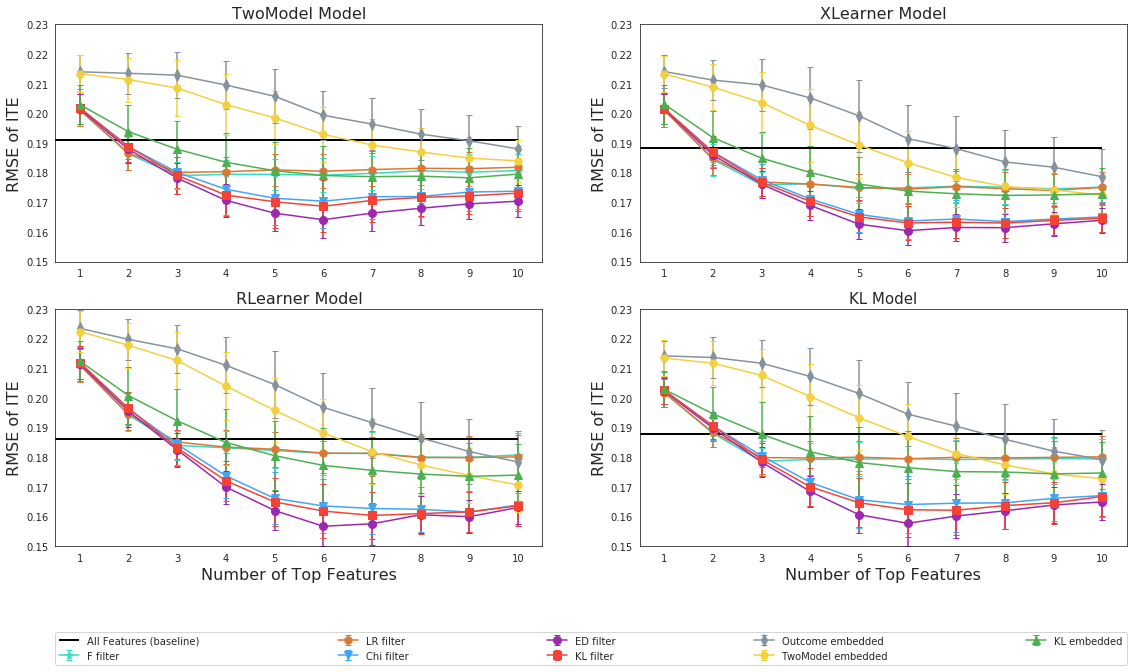

In [27]:
sns.set_style('white')

fs_methods = [
 'F filter',
 'LR filter',
 'Chi filter',
 'ED filter',
 'KL filter',
 'Outcome embedded',
 'TwoModel embedded',
 'KL embedded',]

color_dict = {'TwoModel embedded':'#F4D03F',
              'KL filter':'#F44336',
              'ED filter':'#9C27B0',
              'Chi filter':'#42A5F5',
              'KL embedded':'#4CAF50', 
              'F filter': '#33DCC2', 
              'LR filter':'#DC7633',
              'All':'#1c2833',
              'Outcome embedded':'#85929E'}

marker_dict = {'TwoModel embedded':'H',
              'KL filter':'s',
              'ED filter':'o',
              'Chi filter':'v',
              'KL embedded':'^', 
              'F filter': '*', 
              'LR filter':'h',
              'All':'+',
              'Outcome embedded':'d'}

fig = plt.figure(figsize=(1.2*8*2, 0.8*6*2))

### Two Model
plt.subplot(2, 2, 1)
model = 'TwoModel'
df_plot = df_rmse[df_rmse['model'] == model]

for method in fs_methods:
    plt.errorbar(df_plot[df_plot['feature_selection_method'] == method]['top_n_features'].values, df_plot[df_plot['feature_selection_method'] == method]['rmse'].values, yerr=df_plot[df_plot['feature_selection_method'] == method]['rmse_se'].values, 
                 fmt= 'o-', capsize=3, color = color_dict[method], marker = marker_dict[method], markersize=8, label=method)

plt.hlines(y=df_plot[df_plot['feature_selection_method'] == 'All']['rmse'].values[0], xmin = 0, xmax=10, color='black', linewidth=2, label='All Features (baseline)')
#plt.xlabel('Number of Top Features',fontsize=12)
plt.ylabel('RMSE of ITE',fontsize=16)
plt.xlim(0.5)
plt.ylim(0.15,0.23)
#plt.legend(loc = 0, fontsize=12)
plt.title('%s Model'%(model),fontsize=16)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(np.arange(1,11))

### XLearner
plt.subplot(2, 2, 2)
model = 'XLearner'
df_plot = df_rmse[df_rmse['model'] == model]


for method in fs_methods:
    plt.errorbar(df_plot[df_plot['feature_selection_method'] == method]['top_n_features'].values, df_plot[df_plot['feature_selection_method'] == method]['rmse'].values, yerr=df_plot[df_plot['feature_selection_method'] == method]['rmse_se'].values, 
                 fmt= 'o-', capsize=3, color = color_dict[method], marker = marker_dict[method], markersize=8, label=method)

plt.hlines(y=df_plot[df_plot['feature_selection_method'] == 'All']['rmse'].values[0], xmin = 0, xmax=10, color='black', linewidth=2, label='All Features (baseline)')
#plt.xlabel('Number of Top Features',fontsize=12)
plt.ylabel('RMSE of ITE',fontsize=16)
plt.xlim(0.5)
plt.ylim(0.15,0.23)
#plt.legend(loc = 0, fontsize=12)
plt.title('%s Model'%(model),fontsize=16)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(np.arange(1,11))

### RLearner
plt.subplot(2, 2, 3)
model = 'RLearner'
df_plot = df_rmse[df_rmse['model'] == model]

for method in fs_methods:
    plt.errorbar(df_plot[df_plot['feature_selection_method'] == method]['top_n_features'].values, df_plot[df_plot['feature_selection_method'] == method]['rmse'].values, yerr=df_plot[df_plot['feature_selection_method'] == method]['rmse_se'].values, 
                 fmt= 'o-', capsize=3, color = color_dict[method], marker = marker_dict[method], markersize=8, label=method)

plt.hlines(y=df_plot[df_plot['feature_selection_method'] == 'All']['rmse'].values[0], xmin = 0, xmax=10, color='black', linewidth=2, label='All Features (baseline)')
plt.xlabel('Number of Top Features',fontsize=16)
plt.ylabel('RMSE of ITE',fontsize=16)
plt.xlim(0.5)
plt.ylim(0.15,0.23)
#plt.legend(loc = 0, fontsize=12)
plt.title('%s Model'%(model),fontsize=16)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(np.arange(1,11))

plt.legend(bbox_to_anchor=(0., -0.5, 2.2, .102), loc='lower left',
           ncol=5, mode="expand", borderaxespad=0.)

### KL
plt.subplot(2, 2, 4)
model = 'KL'
df_plot = df_rmse[df_rmse['model'] == model]

for method in fs_methods:
    plt.errorbar(df_plot[df_plot['feature_selection_method'] == method]['top_n_features'].values, df_plot[df_plot['feature_selection_method'] == method]['rmse'].values, yerr=df_plot[df_plot['feature_selection_method'] == method]['rmse_se'].values, 
                 fmt= 'o-', capsize=3, color = color_dict[method], marker = marker_dict[method], markersize=8, label=method)

plt.hlines(y=df_plot[df_plot['feature_selection_method'] == 'All']['rmse'].values[0], xmin = 0, xmax=10, color='black', linewidth=2, label='All Features (baseline)')
plt.xlabel('Number of Top Features',fontsize=16)
plt.ylabel('RMSE of ITE',fontsize=16)
plt.xlim(0.5)
plt.ylim(0.15,0.23)
#plt.legend(loc = 0, fontsize=12)
plt.title('%s Model'%(model),fontsize=15)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(np.arange(1,11))

plt.show()

### Results 1: AUUC difference

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_auuc_perf(result_uplift_benchmark, model_plot, color_dict):
    # 6 Features
    topn_feature_plot = 6
    plt.subplot(1, 3, 1)
    df_plot = result_uplift_benchmark[(result_uplift_benchmark['model'] == model_plot) & (result_uplift_benchmark['top_n_features'] == topn_feature_plot)]
    # Grouped boxplot
    sns.boxplot(x="top_n_features", y="AUUC_pct_difference", hue="feature_selection_method", data=df_plot, palette=color_dict)
    plt.hlines(y=0., xmin = -10, xmax=10, color='black', linewidth=2, label='All Features (baseline)')
    #plt.ylim(ymin=0.5, ymax = 1.0)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.xlabel('Feature Selection Method')
    plt.ylabel('Difference in AUUC')
    plt.ylim(-30,30)
    plt.legend(loc = 0, fontsize=12)
    plt.title('%s with top %s features'%(model_plot , str(topn_feature_plot)),fontsize=20)

    # 8 Features
    topn_feature_plot = 8

    plt.subplot(1, 3, 2)
    df_plot = result_uplift_benchmark[(result_uplift_benchmark['model'] == model_plot) & (result_uplift_benchmark['top_n_features'] == topn_feature_plot)]
    # Grouped boxplot
    sns.boxplot(x="top_n_features", y="AUUC_pct_difference", hue="feature_selection_method", data=df_plot, palette=color_dict)
    plt.hlines(y=0., xmin = -10, xmax=10, color='black', linewidth=2, label='All Features (baseline)')
    #plt.ylim(ymin=0.5, ymax = 1.0)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.xlabel('Feature Selection Method')
    plt.ylabel('Difference in AUUC')
    plt.ylim(-30,30)
    plt.legend(loc = 0, fontsize=12).set_visible(False)
    plt.title('%s with top %s features'%(model_plot , str(topn_feature_plot)),fontsize=20)

    # 10 Features
    topn_feature_plot = 10

    plt.subplot(1, 3, 3)
    df_plot = result_uplift_benchmark[(result_uplift_benchmark['model'] == model_plot) & (result_uplift_benchmark['top_n_features'] == topn_feature_plot)]
    # Grouped boxplot
    sns.boxplot(x="top_n_features", y="AUUC_pct_difference", hue="feature_selection_method", data=df_plot, palette=color_dict)
    plt.hlines(y=0., xmin = -10, xmax=10, color='black', linewidth=2, label='All Features (baseline)')
    #plt.ylim(ymin=0.5, ymax = 1.0)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.xlabel('Feature Selection Method')
    plt.ylabel('Difference in AUUC')
    plt.ylim(-30,30)
    plt.legend(loc = 0, fontsize=12).set_visible(False)
    plt.title('%s with top %s features'%(model_plot , str(topn_feature_plot)),fontsize=20)
    plt.show()


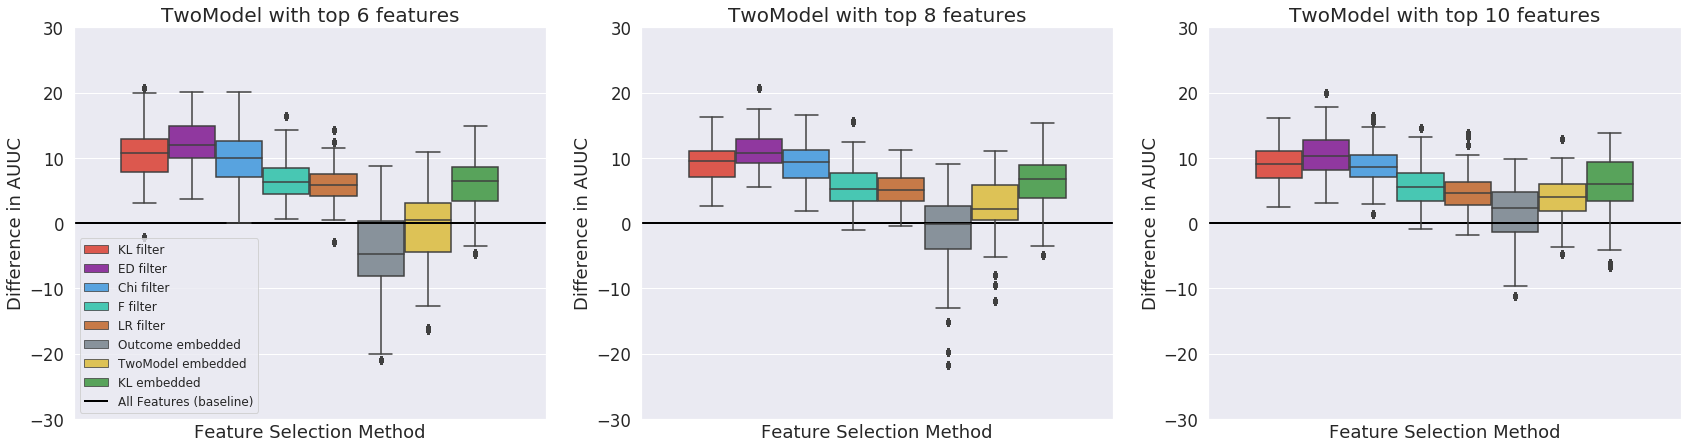

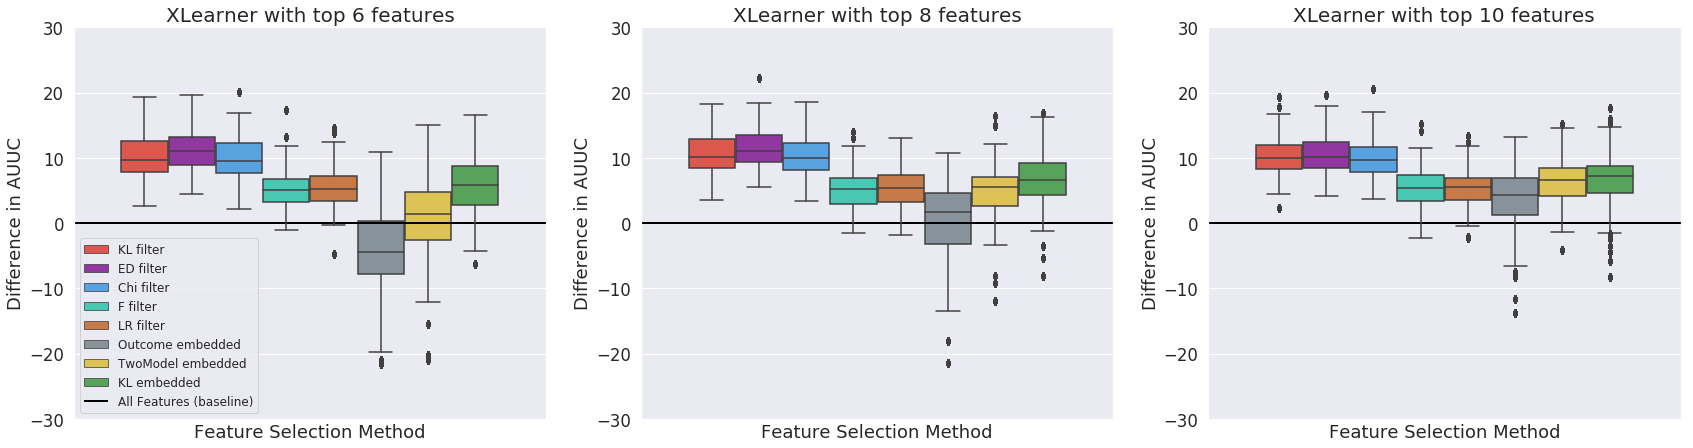

<Figure size 2073.6x518.4 with 0 Axes>

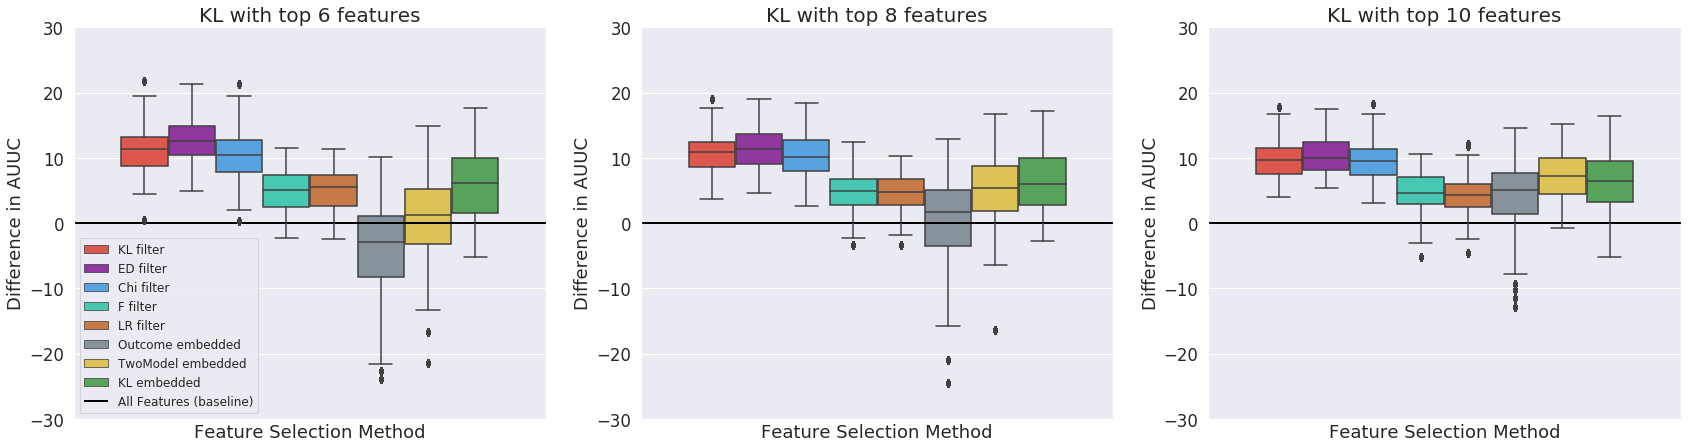

In [29]:
sns.set(font_scale=1.5)
color_dict = {'TwoModel embedded':'#F4D03F',
              'KL filter':'#F44336',
              'ED filter':'#9C27B0',
              'Chi filter':'#42A5F5',
              'KL embedded':'#4CAF50', 
              'F filter': '#33DCC2', 
              'LR filter':'#DC7633',
              'All':'#1c2833',
              'Outcome embedded':'#85929E'}

plt.figure(figsize=(1.2*8*3, 1.2*6))
plot_auuc_perf(result_uplift_benchmark, model_plot='TwoModel',color_dict=color_dict)
plt.figure(figsize=(1.2*8*3, 1.2*6))
plot_auuc_perf(result_uplift_benchmark, model_plot='XLearner',color_dict=color_dict)
plt.figure(figsize=(1.2*8*3, 1.2*6))
#plot_auuc_perf(result_uplift_benchmark, model_plot='RLearner',color_dict=color_dict)
plt.figure(figsize=(1.2*8*3, 1.2*6))
plot_auuc_perf(result_uplift_benchmark, model_plot='KL',color_dict=color_dict)

### Results 2: Uplift Curves

In [30]:
def plot_uplift_curve(result_uplift_benchmark, model_plot, color_dict):
    #plt.figure(figsize=(8*3,7))
    fs_methods = [
     'F filter',
     'LR filter',
     'KL filter',
     'Chi filter',
     'ED filter',
     'Outcome embedded',
     'TwoModel embedded',
     'KL embedded',
     'All',
     ]
    #f, ax = plt.subplots(figsize=(8*3, 8))
    # plt.subplot(1, 3, 1)
    f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(1.3*8*3, 1.3*6))

    # 6 Features
    topn_feature_plot = 6

    df_model = result_uplift_benchmark[(result_uplift_benchmark['model'] == model_plot) & (result_uplift_benchmark['top_n_features'].isin([len(x_name_all),topn_feature_plot]))]
    df_plot =df_model.groupby(['model','feature_selection_method','quantile'])['actual_diff','cum_diff','cum_pct'].mean().reset_index()

    for model_i in range(len(fs_methods)):
        model = fs_methods[model_i]
        deciles = df_plot[(df_plot['feature_selection_method']== model)].reset_index(drop=True)
        deciles = deciles.sort_index(ascending=False)
        cum_pct = deciles['cum_pct']
        cum_pct.index = range(1, 101)
        cum_pct.loc[0]=0
        cum_pct = cum_pct.sort_index()
        ax1.plot(cum_pct, color = color_dict[model])
    ax1.axhline(y=100, color='black', linestyle=':',linewidth=3.0)
    ax1.legend(fs_methods, loc='best')
    ax1.plot((0,100), (0,100), ls="--", c=".3")
    plt.xlabel('% users treated')
    plt.ylabel('% of cumulative lift')
    ax1.title.set_text('%s with top %s features'%(model_plot , str(topn_feature_plot)))

    # 8 Features
    topn_feature_plot = 8

    df_model = result_uplift_benchmark[(result_uplift_benchmark['model'] == model_plot) & (result_uplift_benchmark['top_n_features'].isin([len(x_name_all),topn_feature_plot]))]
    df_plot =df_model.groupby(['model','feature_selection_method','quantile'])['actual_diff','cum_diff','cum_pct'].mean().reset_index()

    for model_i in range(len(fs_methods)):
        model = fs_methods[model_i]
        deciles = df_plot[(df_plot['feature_selection_method']== model)].reset_index(drop=True)
        deciles = deciles.sort_index(ascending=False)
        cum_pct = deciles['cum_pct']
        cum_pct.index = range(1, 101)
        cum_pct.loc[0]=0
        cum_pct = cum_pct.sort_index()
        ax2.plot(cum_pct, color = color_dict[model])
    ax2.axhline(y=100, color='black', linestyle=':',linewidth=3.0)
    ax2.legend(fs_methods, loc='best').set_visible(False)
    ax2.plot((0,100), (0,100), ls="--", c=".3")
    plt.xlabel('% users treated')
    plt.ylabel('% of cumulative lift')
    ax2.title.set_text('%s with top %s features'%(model_plot , str(topn_feature_plot)))

    # 10 Features
    topn_feature_plot = 10

    df_model = result_uplift_benchmark[(result_uplift_benchmark['model'] == model_plot) & (result_uplift_benchmark['top_n_features'].isin([len(x_name_all),topn_feature_plot]))]
    df_plot =df_model.groupby(['model','feature_selection_method','quantile'])['actual_diff','cum_diff','cum_pct'].mean().reset_index()

    for model_i in range(len(fs_methods)):
        model = fs_methods[model_i]
        deciles = df_plot[(df_plot['feature_selection_method']== model)].reset_index(drop=True)
        deciles = deciles.sort_index(ascending=False)
        cum_pct = deciles['cum_pct']
        cum_pct.index = range(1, 101)
        cum_pct.loc[0]=0
        cum_pct = cum_pct.sort_index()
        ax3.plot(cum_pct, color = color_dict[model])
    ax3.axhline(y=100, color='black', linestyle=':',linewidth=3.0)
    ax3.legend(fs_methods, loc='best').set_visible(False)
    ax3.plot((0,100), (0,100), ls="--", c=".3")
    plt.xlabel('% users treated')
    plt.ylabel('% of cumulative lift')
    ax3.title.set_text('%s with top %s features'%(model_plot , str(topn_feature_plot)))

<Figure size 1728x504 with 0 Axes>

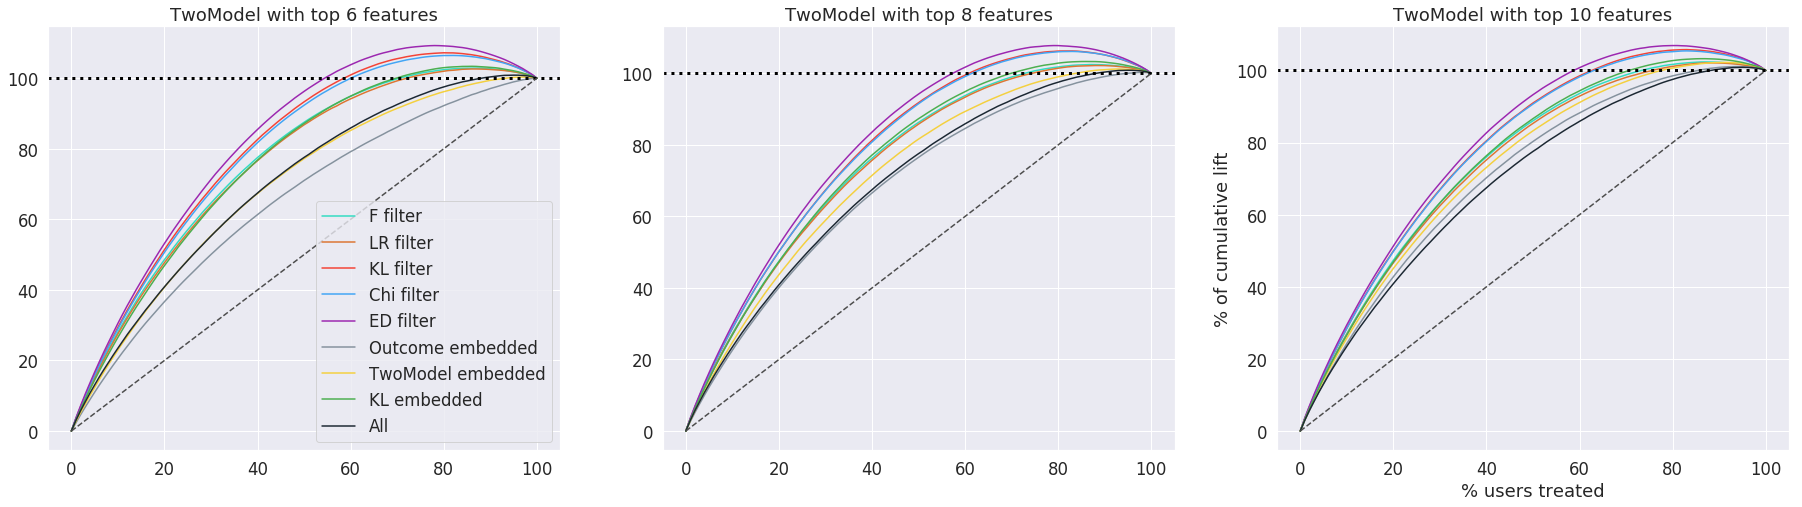

<Figure size 1728x504 with 0 Axes>

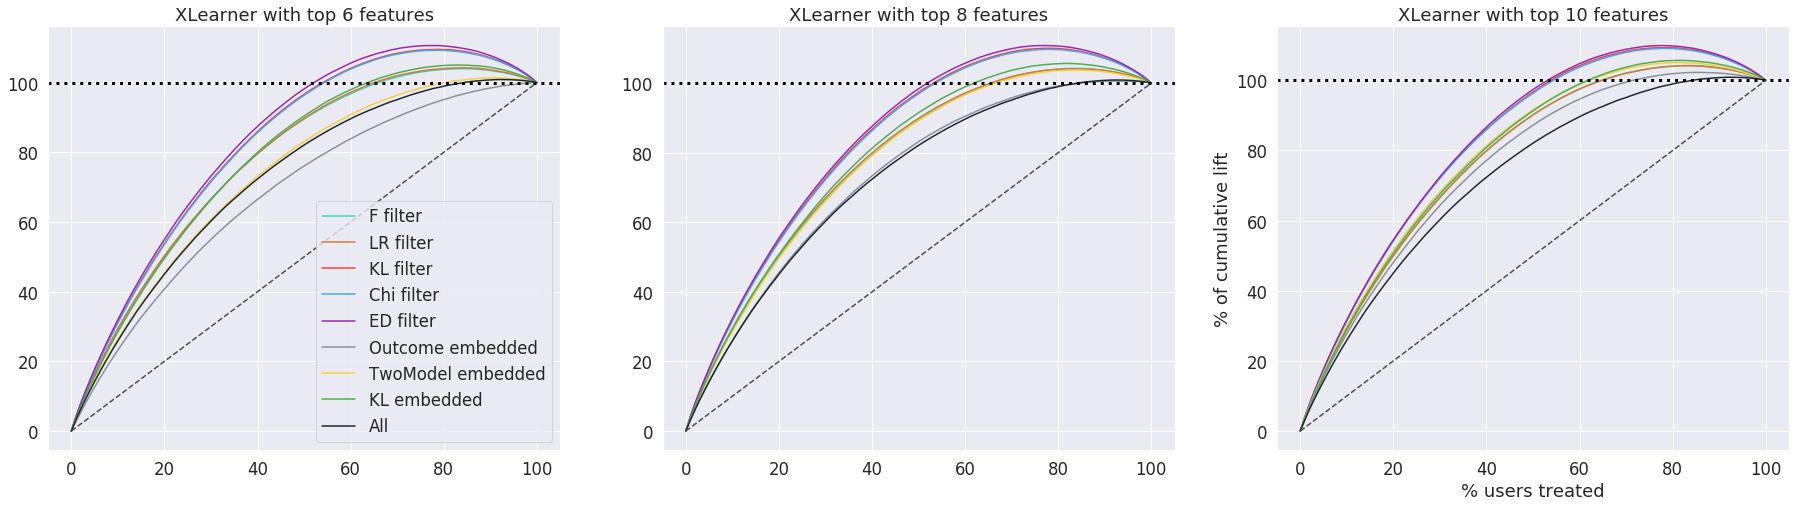

<Figure size 1728x504 with 0 Axes>

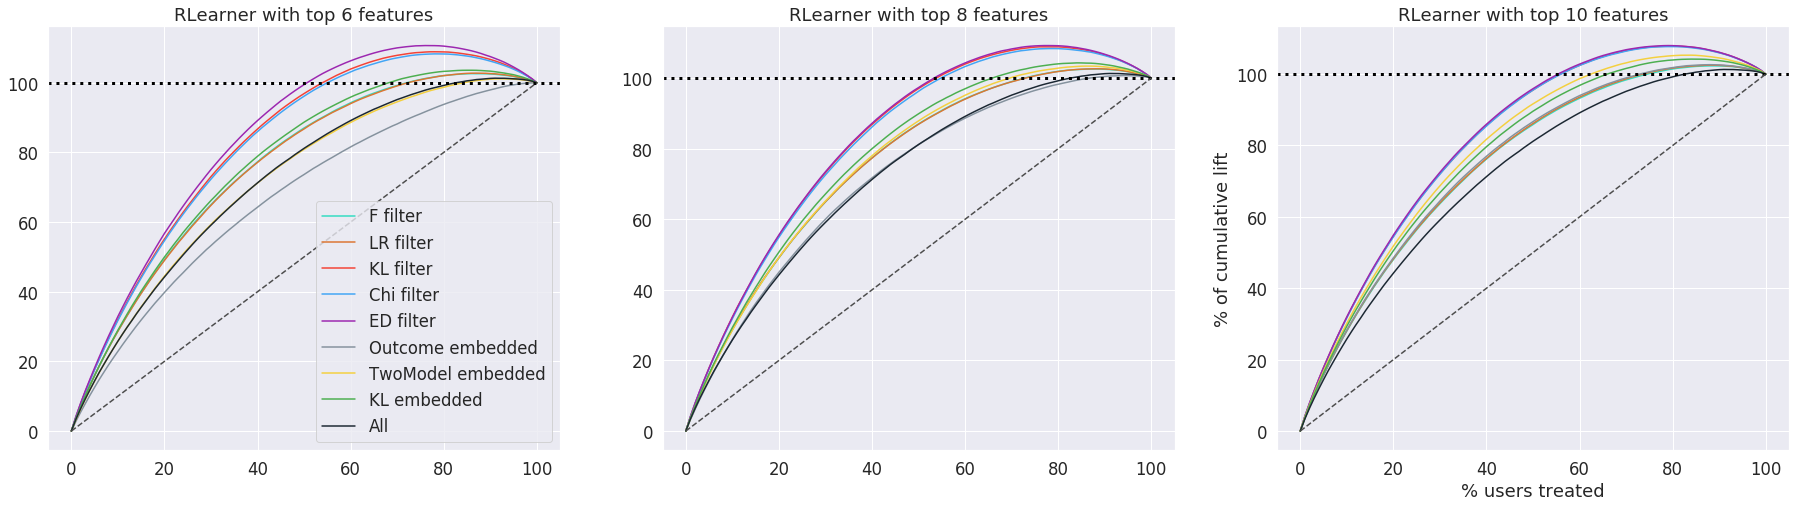

<Figure size 1728x504 with 0 Axes>

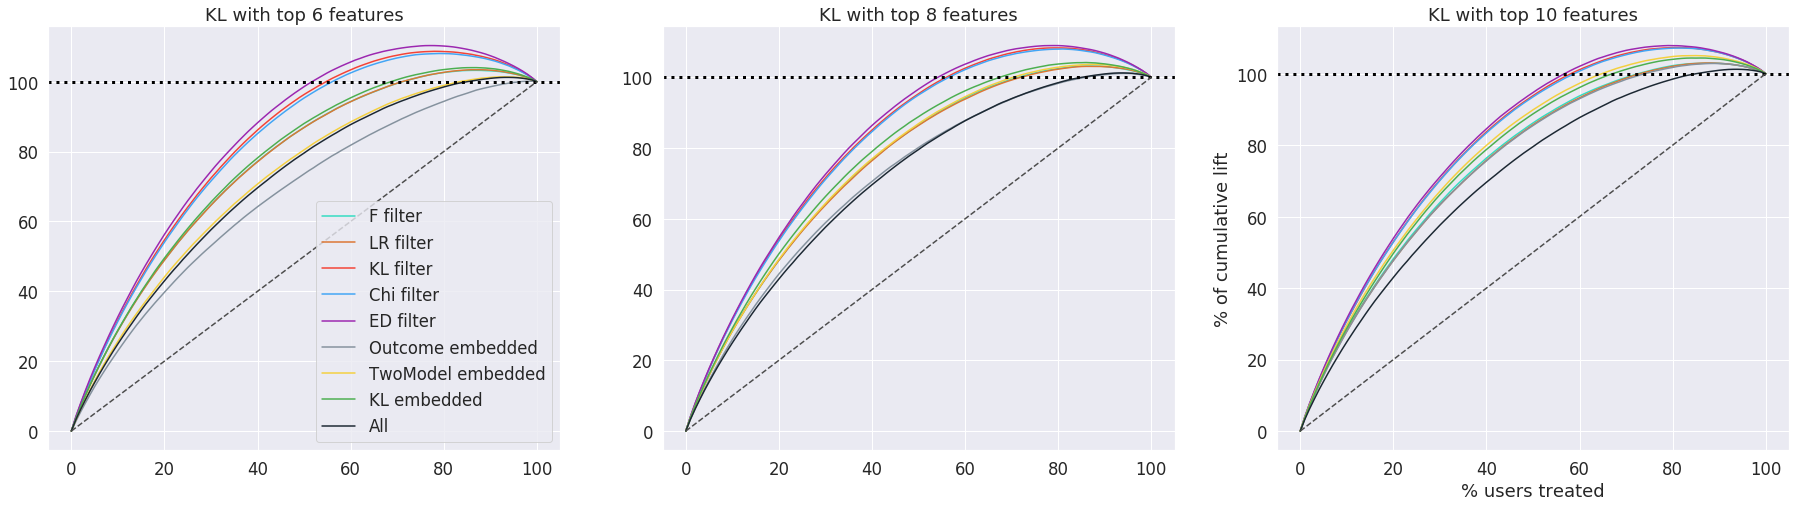

In [31]:
sns.set(font_scale=1.5)
color_dict = {'TwoModel embedded':'#F4D03F',
              'KL filter':'#F44336',
              'ED filter':'#9C27B0',
              'Chi filter':'#42A5F5',
              'KL embedded':'#4CAF50', 
              'F filter': '#33DCC2', 
              'LR filter':'#DC7633',
              'All':'#1c2833',
              'Outcome embedded':'#85929E'}

plt.figure(figsize=(8*3,7))
plot_uplift_curve(result_uplift_benchmark, model_plot='TwoModel',color_dict=color_dict)
plt.figure(figsize=(8*3,7))
plot_uplift_curve(result_uplift_benchmark, model_plot='XLearner',color_dict=color_dict)
plt.figure(figsize=(8*3,7))
plot_uplift_curve(result_uplift_benchmark, model_plot='RLearner',color_dict=color_dict)
plt.figure(figsize=(8*3,7))
plot_uplift_curve(result_uplift_benchmark, model_plot='KL',color_dict=color_dict)

### Calculate feature recall 
Feature recall is defined as proportion of uplift features getting selected in top N features

In [ ]:
#----------------------------------------------------------------------------#
# Simulation: main body -----------------------------------------------------#
#----------------------------------------------------------------------------#

time_start = time.time()
print('Start time: {}'.format(time_start))

#np.random.seed(round(time_start))
np.random.seed(20191119)
seeds_for_setting_simu = np.random.choice(
    999999, size=len(setting_simu_df.index), replace=False
)

counter = 0 

result_feature_recall = pd.DataFrame()

# loop through simulation setting
for ID_setting_simu in range(len(setting_simu_df.index)):
    
    n = setting_simu_df.loc[ID_setting_simu, 'n']
    n_classification_features = setting_simu_df.loc[ID_setting_simu, 'n_classification_features']
    n_classification_informative = setting_simu_df.loc[ID_setting_simu, 'n_classification_informative']
    n_uplift_increase_dict = setting_simu_df.loc[ID_setting_simu, 'n_uplift_increase_dict']
    delta_uplift_increase_dict = setting_simu_df.loc[ID_setting_simu, 'delta_uplift_increase_dict']
    n_classification_redundant_linear = setting_simu_df.loc[ID_setting_simu, 'n_classification_redundant_linear']
    n_classification_redundant_nonlinear = setting_simu_df.loc[ID_setting_simu, 'n_classification_redundant_nonlinear']
    n_classification_repeated = setting_simu_df.loc[ID_setting_simu, 'n_classification_repeated']
    spl_s = setting_simu_df.loc[ID_setting_simu, 'spl_s']
    spl_n_functions = setting_simu_df.loc[ID_setting_simu, 'spl_n_functions']
    spl_n_initial_points = setting_simu_df.loc[ID_setting_simu, 'spl_n_initial_points']
    noise_positive_class_proportion = setting_simu_df.loc[ID_setting_simu, 'noise_positive_class_proportion']
    noise_proportion = setting_simu_df.loc[ID_setting_simu, 'noise_proportion']
    control_positive_class_proportion = setting_simu_df.loc[ID_setting_simu, 'control_positive_class_proportion']

    np.random.seed(seeds_for_setting_simu[ID_setting_simu])
    seeds_for_replicate = np.random.choice(
        999999, size=setting_n_replicate, replace=False
    )
    
    # loop through replicates
    for i_replicate in range(setting_n_replicate):

        # Simulate data
        df1, x_name_all = mySimu.make_uplift_data(
            treatment_group_keys=treatment_group_keys,
            y_name=y_name,
            n=n,
            n_classification_features=n_classification_features,
            n_classification_informative=n_classification_informative,
            n_classification_redundant_linear=n_classification_redundant_linear,
            n_classification_redundant_nonlinear=n_classification_redundant_nonlinear,
            n_classification_repeated=n_classification_repeated,
            n_uplift_increase_dict=n_uplift_increase_dict,
            delta_uplift_increase_dict=delta_uplift_increase_dict,
            spl_s=spl_s,
            spl_n_functions=spl_n_functions,
            spl_n_initial_points=spl_n_initial_points,
            noise_positive_class_proportion=noise_positive_class_proportion,
            noise_proportion=noise_proportion,
            control_positive_class_proportion = control_positive_class_proportion,
            random_seed=seeds_for_replicate[i_replicate]
        )

        #[N] It seems that uplift models does not require 0-1 treatments.
        df1[experiment_group_key_01] = myUpSelect._convert_treatment(data=df1, 
            T_name_before=experiment_group_key, 
            treatment_key=treatment_groups[0]
        )

        # Make separate list of features
        x_name_classification_informative = [x_i for x_i in x_name_all 
                                             if x_i.split('_')[1] == 'informative']
        x_name_uplift = [x_i for x_i in x_name_all if x_i.split('_')[1] == 'uplift']
        x_name_redundant = [x_i for x_i in x_name_all if x_i.split('_')[1] == 'redundant']
        x_name_repeated = [x_i for x_i in x_name_all if x_i.split('_')[1] == 'repeated']
        x_name_irrelevant = [x_i for x_i in x_name_all if x_i.split('_')[1] == 'irrelevant']

        n_uplift = sum([n_i for n_i in n_uplift_increase_dict.values()])
        n_relevant = n_classification_informative + n_uplift

        # Training-testing split
        train_index = mySimu.split_data(n_total=len(df1.index)) # half by default

        df1['is_train'] = 0
        df1.loc[train_index, 'is_train'] = 1

        df1_train = df1.loc[df1['is_train'] == 1]
        df1_test = df1.loc[df1['is_train'] == 0]

        y_train= df1_train[y_name].values
        experiment_groups_train = df1_train[experiment_group_key].values

        y_test = df1_test[y_name].values
        experiment_groups_test = df1_test[experiment_group_key].values

        # Dataset summary
        df1_train_summary_i = df1_train.groupby(['treatment_group_key'])[y_name].mean()
        df1_test_summary_i = df1_test.groupby(['treatment_group_key'])[y_name].mean()
        df1_summary_i = pd.DataFrame([
            [ID_setting_simu, i_replicate]
            + df1_train_summary_i.tolist() 
            + df1_test_summary_i.tolist()],
            columns=(['ID_setting_simu', 'ID_replicate']
                     + ['{}_train'.format(x) for x in df1_train_summary_i.index.tolist()] 
                     + ['{}_test'.format(x) for x in df1_test_summary_i.index.tolist()]), 
        )
        df1_summary = pd.concat([df1_summary, df1_summary_i])
        
        # Apply filter methods
        df_fs_result = pd.DataFrame()
        for filter_method in setting_filter_method:
            # Get the filter-selection result, all features
            filter_result = myUpSelect.filter_result(
                data=df1_train, 
                X_name_list=x_name_all, 
                y_name=y_name, 
                method=filter_method,
                control_group=control_group,
                treatment_group = treatment_group_keys[1],
                experiment_group_column=experiment_group_key
            )
            if df_fs_result.shape[0]==0:
                df_fs_result = filter_result 
            else:
                df_fs_result = pd.concat([df_fs_result,filter_result],axis=0)
        
        # Apply embedded methods  
        # learner dictionary
        learner_dict ={'Outcome': RandomForestClassifier(n_estimators = setting_model_n_estimator[0],
                                                          max_features = setting_model_max_feature[0],
                                                          min_samples_leaf = setting_model_min_samples_leaf[0],
                                                          random_state=0),
                      'TwoModel': UpliftRandomForestClassifier(evaluationFunction='TwoModel',
                                                               control_group=control_group,
                                                               n_estimators = setting_model_n_estimator[0],
                                                               max_features = setting_model_max_feature[0],
                                                               min_samples_leaf = setting_model_min_samples_leaf[0],
                                                               min_samples_treatment=setting_model_min_samples_treatment[0],
                                                               n_reg=setting_model_n_reg[0],
                                                               y_calibration_method=setting_model_y_calibration_method[0],
                                                               w_calibration_method=setting_model_w_calibration_method[0]),
                       'KL': UpliftRandomForestClassifier(evaluationFunction='KL',
                                                               control_group=control_group,
                                                               n_estimators = setting_model_n_estimator[0],
                                                               max_features = setting_model_max_feature[0],
                                                               min_samples_leaf = setting_model_min_samples_leaf[0],
                                                               min_samples_treatment=setting_model_min_samples_treatment[0],
                                                               n_reg=setting_model_n_reg[0],
                                                               y_calibration_method=setting_model_y_calibration_method[0],
                                                               w_calibration_method=setting_model_w_calibration_method[0]),
                      }
        for embedded_method in setting_embedded_method:
            # Get the embedded-selection result, all features
            embedded_result = myUpSelect.embedded_result(
                data=df1_train, 
                X_name_list=x_name_all, 
                y_name=y_name, 
                method=embedded_method,
                learner=learner_dict[embedded_method],
                experiment_group_column=experiment_group_key
            )
            if df_fs_result.shape[0]==0:
                df_fs_result = embedded_result
            else:
                df_fs_result = pd.concat([df_fs_result,embedded_result],axis=0)
        
        
        # Model with Top Features
        for top_n_features in setting_top_n_features:
            # Loop through FS method
            fs_methods = df_fs_result.method.unique()
            for fs_method in fs_methods:

                x_name = df_fs_result[df_fs_result['method']==fs_method]['feature'].head(top_n_features).tolist()

                # Evaluate Feature Recall: % of relevant features selected
                # [result] Relevant features selected
                x_selected_classification_informative = [
                    x_i for x_i in x_name 
                    if x_i in x_name_classification_informative
                ]
                x_selected_uplift = [x_i for x_i in x_name if x_i in x_name_uplift]

                select_proportion_classification_informative = (
                    len(x_selected_classification_informative) 
                    / n_classification_informative
                )
                if n_uplift != 0:
                    select_proportion_uplift = len(x_selected_uplift) / n_uplift
                else: 
                    select_proportion_uplift = 0.
                select_proportion_relevant = (
                    (len(x_selected_classification_informative) + len(x_selected_uplift)) 
                    / n_relevant
                )
                # Uplift feature selected by linear / nonlinear pattern type
                ## f_list = [self.f_linear,self.f_quadratic,self.f_cubic,self.f_relu, self.f_sin, self.f_cos]
                uplift_feature_map = {x_name_uplift[0]: 'Linear',
                                     x_name_uplift[1]: 'Quadratic',
                                     x_name_uplift[2]: 'Cubic',
                                     x_name_uplift[3]: 'Relu',
                                     x_name_uplift[4]: 'Sin',
                                     x_name_uplift[5]: 'Cos',}
                select_proportion_uplift_type ={}
                for key, value in uplift_feature_map.items():
                    select_proportion_uplift_type[value] = 0.
                for xi, x_name_i in enumerate(x_selected_uplift):
                    select_proportion_uplift_type[uplift_feature_map[x_name_i]] = 1.

                result_feature_recall_i = pd.DataFrame({
                    'ID_setting_simu': ID_setting_simu,
                    'sample_size': n,
                    'ID_replicate': i_replicate,
                    'method': fs_method,
                    'top_n_features': top_n_features,
                    'prop_classification_informative': select_proportion_classification_informative,
                    'prop_uplift': select_proportion_uplift,
                    'prop_uplift_linear': select_proportion_uplift_type['Linear'],
                    'prop_uplift_quadratic': select_proportion_uplift_type['Quadratic'],
                    'prop_uplift_cubic': select_proportion_uplift_type['Cubic'],
                    'prop_uplift_relu': select_proportion_uplift_type['Relu'],
                    'prop_uplift_sin': select_proportion_uplift_type['Sin'],
                    'prop_uplift_cos': select_proportion_uplift_type['Cos'],
                    'prop_relevant': select_proportion_relevant,
                }, index=[0])

                result_feature_recall = pd.concat([result_feature_recall, result_feature_recall_i],axis=0)

                counter += 1
                total_time_so_far = result_computing_time['time'].sum()

                # Progress style 1 output - detailed
                print('{} of {} completed!  Time elapsed: {} seconds.'
                      .format(counter, total_runs, total_time_so_far))

Start time: 1581729696.4313035


/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.609733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611728
  

35 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
36 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
37 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
38 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
39 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
40 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
41 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
42 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
43 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
44 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
45 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
46 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
47 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
48 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
49 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
50 of 32000 completed!  Time elapsed: 89

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.597050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611230
  

117 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
118 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
119 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
120 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
121 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
122 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
123 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
124 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
125 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
126 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
127 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
128 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
129 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
130 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
131 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
132 of 32000 completed!  

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.580649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589102
  

190 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
191 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
192 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
193 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
194 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
195 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
196 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
197 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
198 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
199 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
200 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
201 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
202 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
203 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
204 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
205 of 32000 completed!  

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.597637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598737
  

274 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
275 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
276 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
277 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
278 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
279 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
280 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
281 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
282 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
283 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
284 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
285 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
286 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
287 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
288 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
289 of 32000 completed!  

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.596105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598486
  

351 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
352 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
353 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
354 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
355 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
356 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
357 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
358 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
359 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
360 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
361 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
362 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
363 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
364 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
365 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
366 of 32000 completed!  

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.584301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615193
  

434 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
435 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
436 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
437 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
438 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
439 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
440 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
441 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
442 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
443 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
444 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
445 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
446 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
447 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
448 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
449 of 32000 completed!  

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.608711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611819
  

513 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
514 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
515 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
516 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
517 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
518 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
519 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
520 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
521 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
522 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
523 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
524 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
525 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
526 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
527 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
528 of 32000 completed!  

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.609802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611667
  

594 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
595 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
596 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
597 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
598 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
599 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
600 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
601 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
602 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
603 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
604 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
605 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
606 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
607 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
608 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
609 of 32000 completed!  

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.608522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612531
  

675 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
676 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
677 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
678 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
679 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
680 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
681 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
682 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
683 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
684 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
685 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
686 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
687 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
688 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
689 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
690 of 32000 completed!  

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.602747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604792
  

753 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
754 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
755 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
756 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
757 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
758 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
759 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
760 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
761 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
762 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
763 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
764 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
765 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
766 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
767 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
768 of 32000 completed!  

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.594609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595355
  

830 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
831 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
832 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
833 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
834 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
835 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
836 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
837 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
838 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
839 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
840 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
841 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
842 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
843 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
844 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
845 of 32000 completed!  

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.621999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.625194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625183
  

911 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
912 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
913 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
914 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
915 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
916 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
917 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
918 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
919 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
920 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
921 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
922 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
923 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
924 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
925 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
926 of 32000 completed!  

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.608674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609920
  

995 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
996 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
997 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
998 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
999 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1000 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1001 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1002 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1003 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1004 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1005 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1006 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1007 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1008 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1009 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1010 of 32000 c

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.603563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604754
  

1071 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1072 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1073 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1074 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1075 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1076 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1077 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1078 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1079 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1080 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1081 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1082 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1083 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1084 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1085 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1086 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.599059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609142
  

1152 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1153 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1154 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1155 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1156 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1157 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1158 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1159 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1160 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1161 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1162 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1163 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1164 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1165 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1166 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1167 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.594155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594273
  

1236 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1237 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1238 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1239 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1240 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1241 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1242 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1243 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1244 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1245 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1246 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1247 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1248 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1249 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1250 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1251 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.592790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605314
  

1314 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1315 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1316 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1317 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1318 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1319 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1320 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1321 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1322 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1323 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1324 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1325 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1326 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1327 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1328 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1329 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.579689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595877
  

1390 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1391 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1392 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1393 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1394 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1395 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1396 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1397 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1398 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1399 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1400 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1401 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1402 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1403 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1404 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1405 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.589802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609785
  

1474 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1475 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1476 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1477 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1478 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1479 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1480 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1481 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1482 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1483 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1484 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1485 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1486 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1487 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1488 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1489 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.581074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585678
  

1554 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1555 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1556 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1557 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1558 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1559 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1560 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1561 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1562 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1563 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1564 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1565 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1566 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1567 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1568 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1569 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.603138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606035
  

1629 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1630 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1631 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1632 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1633 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1634 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1635 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1636 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1637 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1638 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1639 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1640 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1641 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1642 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1643 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1644 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.599515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610367
  

1715 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1716 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1717 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1718 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1719 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1720 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1721 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1722 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1723 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1724 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1725 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1726 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1727 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1728 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1729 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1730 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.587354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590255
  

1795 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1796 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1797 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1798 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1799 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1800 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1801 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1802 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1803 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1804 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1805 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1806 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1807 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1808 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1809 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1810 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.589503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607232
  

1873 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1874 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1875 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1876 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1877 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1878 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1879 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1880 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1881 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1882 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1883 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1884 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1885 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1886 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1887 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1888 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.602549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610575
  

1953 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1954 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1955 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1956 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1957 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1958 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1959 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1960 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1961 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1962 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1963 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1964 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1965 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1966 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1967 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
1968 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.584929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594290
  

2034 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2035 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2036 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2037 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2038 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2039 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2040 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2041 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2042 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2043 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2044 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2045 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2046 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2047 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2048 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2049 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.603391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609693
  

2112 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2113 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2114 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2115 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2116 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2117 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2118 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2119 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2120 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2121 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2122 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2123 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2124 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2125 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2126 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2127 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.598883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601551
  

2195 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2196 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2197 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2198 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2199 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2200 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2201 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2202 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2203 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2204 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2205 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2206 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2207 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2208 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2209 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2210 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.596925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603735
  

2274 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2275 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2276 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2277 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2278 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2279 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2280 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2281 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2282 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2283 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2284 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2285 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2286 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2287 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2288 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2289 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.607439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610573
  

2353 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2354 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2355 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2356 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2357 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2358 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2359 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2360 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2361 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2362 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2363 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2364 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2365 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2366 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2367 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2368 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.602538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604826
  

2430 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2431 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2432 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2433 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2434 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2435 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2436 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2437 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2438 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2439 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2440 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2441 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2442 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2443 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2444 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2445 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.614459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615702
  

2514 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2515 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2516 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2517 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2518 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2519 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2520 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2521 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2522 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2523 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2524 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2525 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2526 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2527 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2528 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2529 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.603471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620467
  

2592 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2593 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2594 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2595 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2596 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2597 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2598 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2599 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2600 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2601 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2602 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2603 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2604 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2605 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2606 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2607 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.605333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611474
  

2675 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2676 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2677 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2678 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2679 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2680 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2681 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2682 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2683 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2684 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2685 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2686 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2687 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2688 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2689 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2690 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.597441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597774
  

2749 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2750 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2751 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2752 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2753 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2754 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2755 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2756 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2757 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2758 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2759 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2760 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2761 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2762 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2763 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2764 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.607598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609542
  

2834 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2835 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2836 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2837 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2838 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2839 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2840 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2841 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2842 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2843 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2844 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2845 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2846 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2847 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2848 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2849 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.587548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612631
  

2915 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2916 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2917 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2918 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2919 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2920 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2921 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2922 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2923 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2924 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2925 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2926 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2927 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2928 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2929 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2930 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.582669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599665
  

2994 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2995 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2996 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2997 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2998 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
2999 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3000 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3001 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3002 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3003 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3004 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3005 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3006 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3007 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3008 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3009 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.584464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.609470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609512
  

3070 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3071 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3072 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3073 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3074 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3075 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3076 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3077 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3078 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3079 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3080 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3081 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3082 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3083 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3084 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3085 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.593898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603432
  

3152 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3153 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3154 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3155 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3156 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3157 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3158 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3159 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3160 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3161 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3162 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3163 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3164 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3165 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3166 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3167 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.603841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606186
  

3233 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3234 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3235 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3236 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3237 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3238 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3239 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3240 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3241 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3242 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3243 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3244 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3245 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3246 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3247 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3248 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.597669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609139
  

3315 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3316 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3317 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3318 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3319 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3320 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3321 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3322 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3323 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3324 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3325 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3326 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3327 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3328 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3329 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3330 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.585765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600210
  

3391 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3392 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3393 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3394 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3395 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3396 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3397 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3398 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3399 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3400 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3401 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3402 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3403 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3404 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3405 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3406 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.593763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602977
  

3475 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3476 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3477 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3478 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3479 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3480 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3481 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3482 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3483 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3484 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3485 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3486 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3487 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3488 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3489 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3490 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.592388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607058
  

3548 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3549 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3550 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3551 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3552 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3553 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3554 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3555 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3556 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3557 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3558 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3559 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3560 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3561 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3562 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3563 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.619430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621465
  

3632 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3633 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3634 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3635 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3636 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3637 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3638 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3639 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3640 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3641 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3642 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3643 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3644 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3645 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3646 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3647 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.603522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612401
  

3713 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3714 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3715 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3716 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3717 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3718 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3719 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3720 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3721 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3722 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3723 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3724 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3725 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3726 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3727 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3728 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.596913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598673
  

3791 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3792 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3793 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3794 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3795 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3796 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3797 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3798 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3799 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3800 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3801 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3802 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3803 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3804 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3805 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3806 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.594085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598289
  

3870 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3871 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3872 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3873 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3874 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3875 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3876 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3877 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3878 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3879 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3880 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3881 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3882 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3883 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3884 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3885 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.611202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612675
  

3954 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3955 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3956 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3957 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3958 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3959 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3960 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3961 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3962 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3963 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3964 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3965 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3966 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3967 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3968 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
3969 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.591279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594489
  

4033 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4034 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4035 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4036 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4037 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4038 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4039 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4040 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4041 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4042 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4043 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4044 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4045 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4046 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4047 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4048 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.586861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609368
  

4113 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4114 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4115 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4116 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4117 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4118 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4119 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4120 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4121 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4122 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4123 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4124 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4125 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4126 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4127 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4128 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.614462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615244
  

4194 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4195 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4196 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4197 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4198 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4199 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4200 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4201 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4202 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4203 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4204 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4205 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4206 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4207 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4208 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4209 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.575730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591413
  

4274 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4275 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4276 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4277 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4278 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4279 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4280 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4281 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4282 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4283 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4284 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4285 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4286 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4287 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4288 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4289 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.607199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609887
  

4353 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4354 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4355 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4356 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4357 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4358 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4359 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4360 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4361 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4362 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4363 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4364 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4365 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4366 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4367 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4368 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.612391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617623
  

4429 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4430 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4431 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4432 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4433 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4434 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4435 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4436 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4437 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4438 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4439 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4440 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4441 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4442 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4443 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4444 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.595976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597715
  

4514 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4515 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4516 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4517 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4518 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4519 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4520 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4521 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4522 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4523 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4524 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4525 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4526 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4527 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4528 of 32000 completed!  Time elapsed: 8987.46838927269 seconds.
4529 of 32

/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.599471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601877
  

In [35]:
df = result_feature_recall[result_feature_recall['top_n_features']==6]

df_s = df.groupby(['top_n_features','method'])[
       'prop_uplift', 'prop_uplift_linear', 'prop_uplift_quadratic',
       'prop_uplift_cubic', 'prop_uplift_relu', 'prop_uplift_sin',
       'prop_uplift_cos','prop_classification_informative'].mean().reset_index()

df_s = df_s.sort_values(['prop_uplift'],ascending=False)

num_cols = [
       'prop_uplift', 'prop_uplift_linear', 'prop_uplift_quadratic',
       'prop_uplift_cubic', 'prop_uplift_relu', 'prop_uplift_sin',
       'prop_uplift_cos','prop_classification_informative']

for col_i in num_cols:
    df_s[col_i] = df_s[col_i]*100

df_s = df_s.round(1)
df_s

,top_n_features,method,prop_uplift,prop_uplift_linear,prop_uplift_quadratic,prop_uplift_cubic,prop_uplift_relu,prop_uplift_sin,prop_uplift_cos,prop_classification_informative
1,6,ED filter,93.3,99.0,97.0,78.0,97.0,94.0,95.0,1.4
4,6,KL filter,85.0,92.0,90.0,61.0,92.0,85.0,90.0,5.7
0,6,Chi filter,81.7,91.0,86.0,53.0,90.0,84.0,86.0,6.9
3,6,KL embedded,59.8,77.0,90.0,65.0,62.0,25.0,40.0,9.9
2,6,F filter,54.8,100.0,11.0,100.0,100.0,8.0,10.0,8.9
5,6,LR filter,53.8,100.0,7.0,100.0,98.0,7.0,11.0,11.1
7,6,TwoModel embedded,41.0,65.0,11.0,56.0,58.0,10.0,46.0,35.0
6,6,Outcome embedded,27.5,61.0,35.0,23.0,37.0,5.0,4.0,43.1
